# Bengali.AI SEResNeXt training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [1]:
!pip install pretrainedmodels

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

# PATH = "/Users/helen/Desktop/Data/bengaliai-cv19/"
# FEATHER_PATH = "/Users/helen/Desktop/Data/bengaliaicv19feather/"

# # PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/"
# # FEATHER_PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliaicv19feather/"

PATH = "/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/"
FEATHER_PATH = "/home/vemlr/Work/chen_huang/Data/bengaliaicv19feather/"

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_0.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/class_map.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_1.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_3.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_3.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_1.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/sample_submission.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_2.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_2.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_0.parquet


In [4]:
import torch

debug = False
submission=False
batch_size=96
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out='.'
image_size= 128
arch='pretrained'
model_name='ResNext50'

HEIGHT = 137
WIDTH = 236
FACTOR = 0.25
# HEIGHT_NEW = 96
# WIDTH_NEW = 168
HEIGHT_NEW = 64
WIDTH_NEW = 112
# HEIGHT_NEW = int(HEIGHT*FACTOR)
# WIDTH_NEW = int(WIDTH*FACTOR)
print(WIDTH_NEW, HEIGHT_NEW)

112 64


In [5]:
datadir = Path(PATH)
featherdir = Path(FEATHER_PATH)
LR = 5e-4
WD = 1e-4
DP = 0.35
HDIM = 1024
outdir = Path('{}_LR{}_WD{}_DP{}_IM{}-{}_bs{}_autoaug_mix'.format(model_name, LR, WD, DP, HEIGHT_NEW, WIDTH_NEW,
                                                            batch_size))

TH = 20.0

In [6]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [7]:
import cv2
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=image_size, pad=3, thh = 80, thl = 28):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > thh)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < thl] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))


In [8]:
import numpy as np
import pandas as pd
import gc


def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype('uint8') for df in image_df_list]

#     images = []
#     for df in image_df_list:
#         for idx in tqdm(range(len(df))):
#             images.append(crop_resize(df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype('uint8')))
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [9]:
%%time

# train = pd.read_csv(datadir/'train.csv')
train = pd.read_csv('train_with_fold.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0,1,2,3] #if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)

image_df_list 4
CPU times: user 30.7 s, sys: 31 s, total: 1min 1s
Wall time: 7.61 s


In [10]:
print(len(train_labels))
print(len(train))
print(train_labels[200840-1])

200840
200840
[127   2   0]


In [11]:
#  import sys 

# # These are the usual ipython objects, including this one you are creating 
# ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars'] 

# # Get a sorted list of the objects and their sizes 
# sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True) 

<a id="dataset"></a>
# Dataset

In [12]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


This `DatasetMixin` class can be used to define any custom dataset class in pytorch. We can implement `get_example(self, i)` method to return `i`-th data.

Here I return i-th image `x` and `label`, with scaling image to be value ranges between 0~1.

In [13]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


Let's see how this `BengaliAIDataset` work

In [14]:
# train_dataset_noaug = BengaliAIDataset(train_images[:200], train_labels)

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [15]:
# image, label = train_dataset_noaug[0]
# print('image', image.shape, 'label', label)

In [16]:
# print(image[:5,:5])
# print(20/255)

In [17]:
# nrow, ncol = 5, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset_noaug[i]
#     ax.imshow(crop_resize(image, thh = TH/255, thl=28.0/255)) #, cmap='Greys'
#     ax.set_title(f'label: {label}')
# plt.tight_layout()
# plt.show()
# plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [18]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import SimilarityTransform, AffineTransform, warp
import numpy as np
import math


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.85
    max_scale = 1.15
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 10
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle)*np.pi/180.0

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle)*np.pi/180.0

    # --- translation ---
    max_translation = image_size*0.075
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)
    
#     print("rot:{}, shear:{},tx:{},ty:{}".format(rot_angle,shear_angle, tx,ty))
    
    shape = img.shape
    shape_size = shape[:2]
    center = np.float32(shape_size) / 2.
        
    pre = SimilarityTransform(translation=-center)
    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle, translation=(tx,ty)) 
    after = AffineTransform(translation=center)
    total_transform = pre+tform+after
#     total_transform = tform
    transformed_image = warp(img, total_transform.params, mode='constant')
    
    assert transformed_image.ndim == 2
    return transformed_image

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_char_image_thin(image, threshold=40./255., pad = 16):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

def crop_char_image(img0, threshold=TH/255., pad=10):
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > threshold)
    #cropping may cut too much, so we need to add it back
#     xmin = xmin - 5 if (xmin > 5) else 0
#     ymin = ymin - 5 if (ymin > 5) else 0
#     xmax = xmax + 5 if (xmax < WIDTH - 5) else WIDTH
#     ymax = ymax + 5 if (ymax < HEIGHT - 5) else HEIGHT
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28./255.] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return img

# def crop_char_image_new(img0, threshold=TH/255., pad=10):
#     ymin,ymax,xmin,xmax = bbox(img0 > threshold)
#     #cropping may cut too much, so we need to add it back
# #     xmin = xmin - 13 if (xmin > 13) else 0
# #     ymin = ymin - 10 if (ymin > 10) else 0
# #     xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
# #     ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
#     img = img0[ymin:ymax,xmin:xmax]
#     #remove lo intensity pixels as noise
#     img[img < 28./255.] = 0
#     lx, ly = xmax-xmin,ymax-ymin
#     l = max(lx,ly) + pad
#     #make sure that the aspect ratio is kept in rescaling
#     img = np.pad(img, [(pad//2,), (pad//2,)], mode='constant')
#     return img

def resize(image, size=(WIDTH_NEW, HEIGHT_NEW)):
    return cv2.resize(image, size)

## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear

In [19]:
# nrow, ncol = 3, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset_noaug[2]
#     if i ==0:
#         ax.imshow(image, cmap='Greys')
#     else:
#         ax.imshow(resize(crop_char_image_thin(affine_image(crop_char_image(image)))), cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()
# # crop_resize(image, thh = 80.0/255, thl=28.0/255, pad=16)

In [20]:
# nrow, ncol = 3, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# PAD = 20
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset_noaug[2]
#     if i ==0:
#         ax.imshow(image, cmap='Greys')
#     elif i==1:
#         ax.imshow(crop_char_image(image), cmap='Greys')
#     else:
#         ax.imshow(resize((affine_image(crop_char_image(image)))), cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

## crop image

Here I crop image

In [21]:
# nrow, ncol = 5, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset_noaug[i]
#     ax.imshow(crop_char_image(image, threshold=TH/255.), cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

## resize image

We need to resize image after crop, to align image size for CNN batch training.

whole process: crop_Char_imgage->affine->crop_char_image_thin->resize

In [22]:
# nrow, ncol = 5, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset_noaug[i]
#     ax.imshow(resize((affine_image((crop_char_image(image, threshold=TH/255.))))), cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [23]:
# from albumentations import (
#     HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
#     Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
#     IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,IAAAffine,
#     IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
# )

In [24]:
# affine_train_transform = Compose([
#     OneOf([
#         ShiftScaleRotate(scale_limit=.15, rotate_limit=20, border_mode=cv2.BORDER_CONSTANT),
#         IAAAffine(shear=20, mode='constant'),
#         IAAPerspective(),
#     ])
# ])

In [25]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']

# class Transform:
#     def __init__(self, affine=True, crop=True, size=(64, 64),
#                  normalize=True, train=True, threshold=TH,
#                  sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
#                  grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
#                  piece_affine_ratio=0., ssr_ratio=0.):
#         self.affine = affine
#         self.crop = crop
#         self.size = size
#         self.normalize = normalize
#         self.train = train
#         self.threshold = threshold / 255.
#         self.sigma = sigma / 255.

#         self.blur_ratio = blur_ratio
#         self.noise_ratio = noise_ratio
#         self.cutout_ratio = cutout_ratio
#         self.grid_distortion_ratio = grid_distortion_ratio
#         self.elastic_distortion_ratio = elastic_distortion_ratio
#         self.random_brightness_ratio = random_brightness_ratio
#         self.piece_affine_ratio = piece_affine_ratio
#         self.ssr_ratio = ssr_ratio

#     def __call__(self, example):
#         if self.train:
#             x, y = example
#         else:
#             x = example
            
#         # --- Train/Test common preprocessing ---
#         if self.crop:
#             x = crop_char_image(x, threshold=self.threshold)
            
#         # --- Augmentation ---
# #         if self.affine:
# #             x = affine_image(x)
#         if self.affine:
#             x = apply_aug(affine_train_transform, x)
            
# #         if self.crop:
# #             x = crop_char_image_thin(x, threshold=self.threshold)        
            
#         if self.size is not None:
#             x = resize(x, size=self.size)
            
#         h, w = x.shape

#         if self.sigma > 0.:
#             x = add_gaussian_noise(x, sigma=self.sigma)

#         # albumentations...
#         x = x.astype(np.float32)
#         assert x.ndim == 2
#         # 1. blur
#         if _evaluate_ratio(self.blur_ratio):
#             r = np.random.uniform()
#             if r < 0.25:
#                 x = apply_aug(A.Blur(p=1.0), x)
#             elif r < 0.5:
#                 x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
#             elif r < 0.75:
#                 x = apply_aug(A.GaussianBlur(p=1.0), x)
#             else:
#                 x = apply_aug(A.MotionBlur(p=1.0), x)

#         if _evaluate_ratio(self.noise_ratio):
#             r = np.random.uniform()
#             if r < 0.50:
#                 x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
#             else:
#                 x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

#         if _evaluate_ratio(self.cutout_ratio):
#             r = np.random.uniform()
#             if r < 0.5:
#                 x = apply_aug(A.CoarseDropout(max_holes=4, max_height=h//8, max_width=w//8, p=1.0), x)
#             else:
#                 x = apply_aug(A.Cutout(num_holes=1,  max_h_size=h//3, max_w_size=w//3, p=1.0),x)  # Deprecated...

#         if _evaluate_ratio(self.grid_distortion_ratio):
#             x = apply_aug(A.GridDistortion(p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

#         if _evaluate_ratio(self.elastic_distortion_ratio):
#             x = apply_aug(A.ElasticTransform(
#                 sigma=50, alpha=1, alpha_affine=10, p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

#         if _evaluate_ratio(self.random_brightness_ratio):
#             # A.RandomBrightness(p=1.0)  # Deprecated...
#             # A.RandomContrast(p=1.0)    # Deprecated...
#             x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

#         if _evaluate_ratio(self.piece_affine_ratio):
#             x = apply_aug(A.IAAPiecewiseAffine(p=1.0, mode='constant'), x)

#         if _evaluate_ratio(self.ssr_ratio):
#             x = apply_aug(A.ShiftScaleRotate(
#                 shift_limit=0.0625,
#                 scale_limit=0.1,
#                 rotate_limit=10,
#                 p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

#         if self.normalize:
# #             x = (x.astype(np.float32) - 0.0692) / 0.2051  ##ORG
#             x = (x.astype(np.float32) - 0.449) / 0.226 ##Imagenet
#         if x.ndim == 2:
#             x = x[None, :, :]
#         x = x.astype(np.float32)
#         if self.train:
#             y = y.astype(np.int64)
#             return x, y
#         else:
#             return x

In [26]:
# # train_transform = Transform(
# #     size=(image_size, image_size), 
# #     sigma=-1., blur_ratio=0.2, noise_ratio=0.1, cutout_ratio=0.4,
# #     grid_distortion_ratio=0.1, random_brightness_ratio=0.3,
# #     piece_affine_ratio=0.2, ssr_ratio=0.2, elastic_distortion_ratio=0.3) #threshold=20.,
# # transform = Transform(size=(image_size, image_size)
# train_transform = Transform(affine=True,
#     crop=False, size=(WIDTH_NEW, HEIGHT_NEW), cutout_ratio=0.4) #threshold=20.,
# train_dataset = BengaliAIDataset(train_images[:200], train_labels,
#                                  transform=train_transform)

By setting `transform`, its function is called **every time** when we access to the index. Dataset returns different `image` every time! which is useful for training with data augmentation.

In [27]:
# nrow, ncol = 5, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset[3]
#     ax.imshow(image[0], cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

Let's final check the processed images, which will be trained by the model.

In [28]:
# nrow, ncol = 5, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset[i+100]
#     ax.imshow(image[0], cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

In [29]:
# nrow, ncol = 5, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset_noaug[i+100]
#     ax.imshow(image, cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

In [30]:
%reload_ext autoreload
%autoreload 2

from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import pdb
from autoaugment import ImageNetPolicy, CIFAR10Policy, SVHNPolicy, SubPolicy

In [31]:
import PIL
print("Using Pillow version {}. Upgrade using 'pip install Pillow -U'".format(PIL.__version__))

Using Pillow version 6.2.0. Upgrade using 'pip install Pillow -U'


In [32]:
class AutoTransform:
    def __init__(self, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=TH,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., 
                 piece_affine_ratio=0., auto_aug=False):
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.auto_policy = SVHNPolicy()
        self.auto_aug = auto_aug

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
            
        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
            
#         if self.crop:
#             x = crop_char_image_thin(x, threshold=self.threshold)

        if self.size is not None:
            x = resize(x, size=self.size)
            
        x = np.transpose(np.stack((x, x, x), axis=0),(1,2,0))
        
        if self.auto_aug:
            x_int = Image.fromarray((x*255).astype(np.uint8))
            x_int = x_int.resize((224, 224))
            x_int = self.auto_policy(x_int)
            x = numpy.asarray(x_int.resize(self.size)).astype(np.float32) / 255.
        
        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
#         assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
            r = np.random.uniform()
            if r < 0.5:
                x = apply_aug(A.CoarseDropout(max_holes=4, max_height=image_size//8, max_width=image_size//8, p=1.0), x)
            else:
                x = apply_aug(A.Cutout(num_holes=1,  max_h_size=image_size//3, max_w_size=image_size//3, p=1.0),x)  # Deprecated...

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)


        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0, mode='constant'), x)


        if self.normalize:
#             x = (x.astype(np.float32) - 0.0692) / 0.2051  ##ORG
            x = (x.astype(np.float32) - 0.449) / 0.226 ##Imagenet
#         if x.ndim == 2:
#             x = x[None, :, :]
        x = x.astype(np.float32)
        x = np.transpose(x,(2,0,1))
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [33]:
train_auto_transform = AutoTransform(auto_aug=True, crop=False, 
    size=(WIDTH_NEW, HEIGHT_NEW)) #threshold=20.,
train_auto_dataset = BengaliAIDataset(train_images[:200], train_labels,
                                 transform=train_auto_transform)


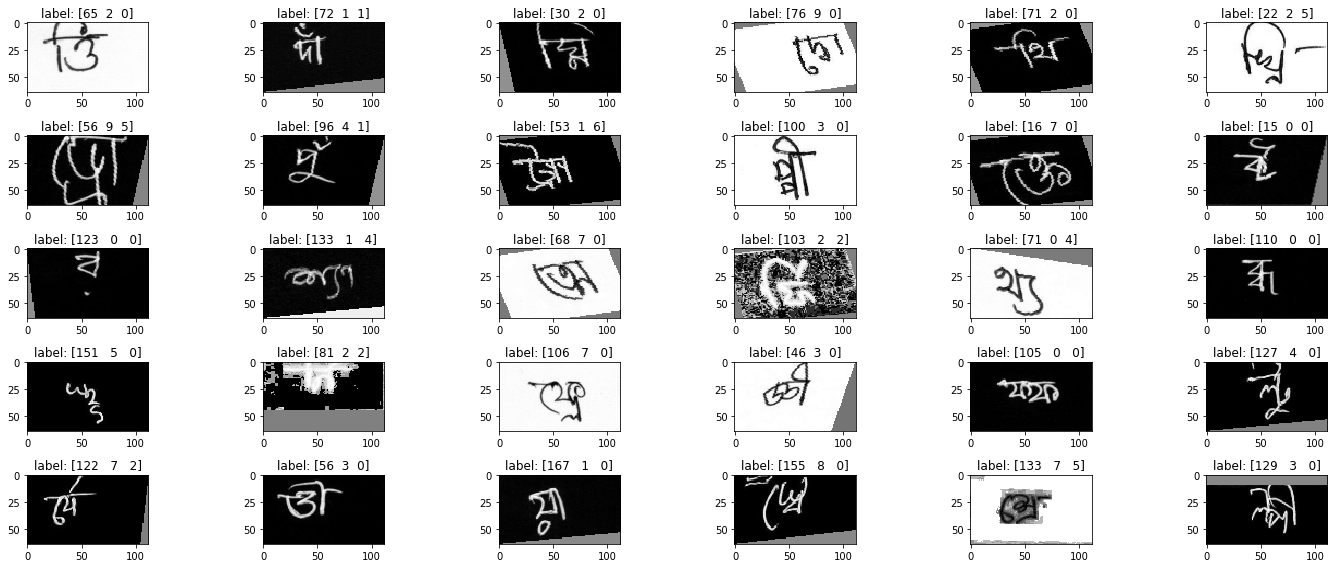

In [34]:
nrow, ncol = 5, 6
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_auto_dataset[i+100]
#     print(np.max(image), np.min(image))
    ax.imshow(np.transpose((image-np.min(image))/(np.max(image)-np.min(image)).astype('float'),(1,2,0)), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [35]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [36]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [37]:
a = np.array([2,3])
b = np.array([4,5,6])

In [38]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [39]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [40]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class ClassifierNew(nn.Module):
    def __init__(self, inp = 2048, h1=1024, num_class = [1000,1,1], dropout_ratio=0.35):
        super().__init__()
        self.ap = nn.AdaptiveAvgPool2d(1)
        self.mp = nn.AdaptiveMaxPool2d(1)
        self.fla = Flatten()
#         self.bn0 = nn.BatchNorm1d(inp*2,eps=1e-05, momentum=0.1, affine=True)
        self.dropout0 = nn.Dropout(dropout_ratio)
        
        self.logit = nn.ModuleList(
            [ nn.Linear(inp*2, c) for c in num_class]
        )
#         self.fc1 = nn.Linear(inp*2, h1)
#         self.bn1 = nn.BatchNorm1d(h1,eps=1e-05, momentum=0.1, affine=True)
#         self.dropout1 = nn.Dropout(dropout_ratio)
#         self.fc2 = nn.Linear(h1, out)
        
    def forward(self, x):
        ap = self.ap(x)
        mp = self.mp(x)
        x = torch.cat((ap,mp),dim=1)
        x = self.fla(x)
#         x = self.bn0(x)
        x = self.dropout0(x)
        logit = [l(x) for l in self.logit]
#         x = F.relu(self.fc1(x))
#         x = self.bn1(x)
#         x = self.dropout1(x)         
#         x = self.fc2(x)
        return logit

In [41]:
# ap = nn.AdaptiveAvgPool2d((1,1))
# mp = nn.AdaptiveMaxPool2d((1,1))
# x = np.random.rand(5,4,4)
# print(x)
# print(ap)
# x1 = torch.nn.functional.adaptive_avg_pool2d(x, (1,1))
# print(x1)

In [42]:
a = torch.Tensor([[1,2],[3,4]])
b = torch.sum(a,dim=(-1,-2))
print(b)

tensor(10.)


In [43]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [44]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
import collections
try:
    from collections import OrderedDict
except ImportError:
    OrderedDict = dict

from seresnext import *    

class PretrainedCNN(nn.Module):
    
    def load_pretrain(self, skip=['block0.','logit.'], is_print=True):
        load_pretrain(self, skip, pretrain_file=PRETRAIN_FILE, conversion=CONVERSION, is_print=is_print)
        
    def __init__(self, model_name='se_resnext101_32x4d',
                 in_channels=1, num_class=[10], use_bn=True,
                 pretrained='imagenet', dropout_ratio=0):
        super(PretrainedCNN, self).__init__()
#         self.conv0 = nn.Conv2d(
#             in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
#         self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
# #         print(self.base_model)
#         names = []
#         for name, child in self.base_model.named_children():
#             names.append(name)
            
#         arch = self.base_model
#         arch = list(arch.children())
#         #saving the weights of the forst conv in w
#         w = arch[0][0].weight
#         #creating new Conv2d to accept 1 channel 
#         arch[0][0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         #substituting weights of newly created Conv2d with w from but we have to take mean
#         #to go from  3 channel to 1
#         arch[0][0].weight = nn.Parameter(torch.mean(w, dim=1, keepdim=True))
#         arch = nn.Sequential(OrderedDict([(names[k], arch[k]) for k in range(len(names))]))
# #         print(arch)
#         self.base_model = arch
# #         print("#######################################")
# #         print(self.base_model)
#         activation = F.leaky_relu
#         self.do_pooling = True
#         if self.do_pooling:
#             inch = self.base_model.last_linear.in_features
#         else:
#             inch = None

        e = ResNext50()

        self.block0 = e.block0
        self.block1 = e.block1
        self.block2 = e.block2
        self.block3 = e.block3
        self.block4 = e.block4
        e = None  #dropped
        inch = 2048
        hdim = HDIM
        self.classifer = ClassifierNew(inp = inch, h1=hdim, num_class = num_class, dropout_ratio=dropout_ratio)
#         lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
#         lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
#         self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        
#         h = self.base_model.layer0(x)
#         h = self.base_model.layer1(h)
#         h = self.base_model.layer2(h)
#         h = self.base_model.layer3(h)
#         h = self.base_model.layer4(h) 

        batch_size,C,H,W = x.shape
        if (H,W) !=(HEIGHT_NEW, WIDTH_NEW):
            x = F.interpolate(x,size=(HEIGHT_NEW, WIDTH_NEW), mode='bilinear',align_corners=False)
            
#         x = x.repeat(1,3,1,1)
        x = self.block0(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        h = self.classifer(x)

        return h

In [45]:
def print_base_layers(predictor):
    print("base model layer names::")
    for name, child in predictor.base_model.named_children():
        print(name)
        
def print_base_grad_status(predictor):
    print("base model grad status::")
    for name, child in predictor.base_model.named_children():
        print(name)
        for param in child.parameters():
            print(param.requires_grad)

In [46]:
# print_grad_status(predictortmp)

In [47]:
def frozen_basiclayers(predictor):
    for name, child in predictor.base_model.named_children():
        if name in ['layer0','layer1','layer2','layer3']:
            print(name + ' is frozen')
            for param in child.parameters():
                param.requires_grad = False
        else:
            print(name + ' is unfrozen')
            for param in child.parameters():
                param.requires_grad = True

In [48]:
def unfrozen_basiclayers(predictor):
    for name, child in predictor.base_model.named_children():
        for param in child.parameters():
            param.requires_grad = True

In [49]:
# frozen_basiclayers(predictortmp)
# print_grad_status(predictortmp)

In [50]:
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)

n_total 186


In [51]:
# predictortmp = PretrainedCNN(in_channels=1, num_class=[n_grapheme, n_vowel, n_consonant], model_name=model_name, pretrained="imagenet")
# for name, child in predictortmp.named_children():
#     print(name)
# print_base_layers(predictortmp)

In [52]:
# def get_optimizer_adam(classifier, learning_rate=1e-3, weight_decay=0.0):
    
#     base_params = list(map(id, classifier.predictor.base_model.parameters()))
#     fast_learned_params = filter(lambda p: id(p) not in base_params, 
#                                  classifier.parameters())
# #     print("base_params len:", len(base_params))
# #     print("fast_learned_params len:", len(list(fast_learned_params)))
#     lr_100 = max(learning_rate/100, 1e-6)
#     lr_10 = max(learning_rate/10, 5e-6)
#     optimizer = torch.optim.Adam(
#     [
#         dict(params=classifier.predictor.base_model.layer0.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer1.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer2.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer3.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer4.parameters(), lr=lr_10),        
#         dict(params=classifier.predictor.base_model.avg_pool.parameters(), lr=lr_10),
#         dict(params=classifier.predictor.base_model.last_linear.parameters(), lr=lr_10),
#         {'params': fast_learned_params},
#     ], lr = learning_rate, weight_decay=weight_decay)
    
#     return optimizer

In [53]:
# def get_optimizer_adam(classifier, learning_rate=1e-3, weight_decay=0.0):
    
#     base_params = list(map(id, classifier.predictor.base_model.parameters()))
#     fast_learned_params = filter(lambda p: id(p) not in base_params, 
#                                  classifier.parameters())
# #     print("base_params len:", len(base_params))
# #     print("fast_learned_params len:", len(list(fast_learned_params)))
#     lr_100 = max(learning_rate/100, 1e-7)
#     lr_10 = max(learning_rate/10, 1e-7)
#     optimizer = torch.optim.Adam(
#     [
#         dict(params=classifier.predictor.base_model.layer0.parameters(), lr=lr_10),
#         dict(params=classifier.predictor.base_model.layer1.parameters(), lr=lr_10),
#         dict(params=classifier.predictor.base_model.layer2.parameters(), lr=lr_10),
#         dict(params=classifier.predictor.base_model.layer3.parameters(), lr=lr_10),
#         dict(params=classifier.predictor.base_model.layer4.parameters(), lr=learning_rate),        
#         dict(params=classifier.predictor.base_model.avg_pool.parameters(), lr=learning_rate),
#         dict(params=classifier.predictor.base_model.last_linear.parameters(), lr=learning_rate),
#         {'params': fast_learned_params},
#     ], lr = learning_rate, weight_decay=weight_decay)
    
#     return optimizer

In [54]:
def get_optimizer_adam(classifier, learning_rate=1e-3, weight_decay=0.0):
    
    base_params = list(map(id, classifier.predictor.parameters()))
    fast_learned_params = filter(lambda p: id(p) not in base_params, 
                                 classifier.parameters())
#     print("base_params len:", len(base_params))
#     print("fast_learned_params len:", len(list(fast_learned_params)))
    lr_100 = max(learning_rate/100, 1e-7)
    lr_10 = max(learning_rate/10, 1e-7)
    optimizer = torch.optim.Adam(
    [
        dict(params=classifier.predictor.block0.parameters(), lr=lr_10),
        dict(params=classifier.predictor.block1.parameters(), lr=lr_10),
        dict(params=classifier.predictor.block2.parameters(), lr=lr_10),
        dict(params=classifier.predictor.block3.parameters(), lr=lr_10),
        dict(params=classifier.predictor.block4.parameters(), lr=learning_rate),
        {'params': fast_learned_params},
    ], lr = learning_rate, weight_decay=weight_decay)
    
    return optimizer

## Classifier

In [55]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix(data, y, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = y[:,0][indices]
    shuffled_targets2 = y[:,1][indices]
    shuffled_targets3 = y[:,2][indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [y[:,0], shuffled_targets1, y[:,1], shuffled_targets2, y[:,2], shuffled_targets3, lam]
    return data, targets

def mixup(data, y, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = y[:,0][indices]
    shuffled_targets2 = y[:,1][indices]
    shuffled_targets3 = y[:,2][indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [y[:,0], shuffled_targets1, y[:,1], shuffled_targets2, y[:,2], shuffled_targets3, lam]

    return data, targets

In [56]:
def cutmix_criterion(pred, targets):
    if isinstance(pred, list):
        assert len(pred) == 3
        preds = pred
    else:
        assert pred.shape[1] == self.n_total_class
        preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return (2*lam * criterion(preds[0], targets1) + (1 - lam) * criterion(preds[0], targets2), 
            lam * criterion(preds[1], targets3) + (1 - lam) * criterion(preds[1], targets4),
            lam * criterion(preds[2], targets5) + (1 - lam) * criterion(preds[2], targets6))

def mixup_criterion(pred, targets):
    if isinstance(pred, list):
        assert len(pred) == 3
        preds = pred
    else:
        assert pred.shape[1] == self.n_total_class
        preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return (2*lam * criterion(preds[0], targets1) + (1 - lam) * criterion(preds[0], targets2),
           lam * criterion(preds[1], targets3) + (1 - lam) * criterion(preds[1], targets4),
           lam * criterion(preds[2], targets5) + (1 - lam) * criterion(preds[2], targets6))

In [57]:
a = np.random.rand(1)
print(np.random.rand())

0.3070188949445265


In [58]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    if isinstance(acc, torch.Tensor):
        acc = acc.item()
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']

    def forward(self, x, y=None):
        
        if np.random.rand()<0.5:
            x, targets = mixup(x, y, 0.2)
            pred = self.predictor(x)
            loss_grapheme, loss_vowel, loss_consonant= mixup_criterion(pred, targets) 
        else:
            x, targets = cutmix(x, y, 0.2)
            pred = self.predictor(x)
            loss_grapheme, loss_vowel, loss_consonant = cutmix_criterion(pred, targets) 
        
        if isinstance(pred, list):
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels


In [59]:
# classifiertmp = BengaliClassifier(predictortmp).to(device)
# # for name, child in classifiertmp.named_children():
# #     print(name)
# # optimizertmp = get_optimizer_adam(classifiertmp)
# # print(optimizertmp)

# ctmp_params = list(map(id, classifiertmp.parameters()))
# print(len(ctmp_params))

# pbtmp_params = list(map(id, predictortmp.base_model.parameters()))
# print(len(pbtmp_params))

# pcftmp_params = list(map(id, predictortmp.classifer.parameters()))
# print(len(pcftmp_params))

# opt_tmp = get_optimizer_adam(classifiertmp)
# print(opt_tmp)

<a id="train"></a>
# Training code


In [60]:
# --- Model ---
device = torch.device(device)

def schedule_lr(metrics):
    avg_mae = metrics['loss']
    # --- update lr ---
    lr = scheduler.optimizer.param_groups[-1]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

## prepare data

In [61]:
from logging import getLogger
import numpy
import os
from time import perf_counter
import argparse
from distutils.util import strtobool
import torch
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

import pandas as pd
import torch
import json


def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


In [62]:
class LogReport:
    def __init__(self, dirpath=None, logger=None):
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, epoch, iteration, train_metrics, val_metrics, mode):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': epoch,
                'iteration': iteration}
        
        elem.update({f'train/{key}': value
                     for key, value in train_metrics.items()})
        
        elem.update({f'val/{key}': value
             for key, value in val_metrics.items()})
        
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
#         print("mode in log type:{}, val:{}".format(type(mode), mode))
        elem['mode'] = str(mode)
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            elif isinstance(value, str):
                msg += f'{key} {value} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df

In [63]:
class ModelSnapshotHandler:
    def __init__(self, model, filepath='model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self):
        self.count += 1
        filepath = self.filepath.format(count=self.count)
        torch.save(self.model.state_dict(), filepath)

In [64]:
import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    if not isinstance(pred_y, list):
        pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(y[:, 0], pred_labels[0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(y[:, 1], pred_labels[1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(y[:, 2], pred_labels[2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score

In [65]:
loss_recall_names =  ['loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant', 'recall']

In [66]:
def train_model(epoch, data_loader, log_report, n_train_call):
    classifier.train()
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    n_tag = 0
    for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
        n_sub = img_batch.shape[0]
        img_batch = img_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        loss, metrics, pred_y = classifier(img_batch, regr_batch)
        
        recall = macro_recall(pred_y, regr_batch)
        metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
        for key, val in metrics.items():
                metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)
                
        n_tag = n_tag + n_sub
        n_train_call[0] += n_sub
        
        loss.backward()
        optimizer.step()
        
    return metrics_total, n_train_call

In [67]:
def evaluate_model(epoch, data_loader, log_report):
    classifier.eval()
    n_tag = 0
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    with torch.no_grad():
        for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
            n_sub = img_batch.shape[0]
            img_batch = img_batch.to(device)
            regr_batch = regr_batch.to(device)

            _, metrics, pred_y = classifier(img_batch, regr_batch)
        
            recall = macro_recall(pred_y, regr_batch)
            metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
            for key, val in metrics.items():
                    metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)

            n_tag = n_tag + n_sub
        
        schedule_lr(metrics_total)   
        return metrics_total


## Train


In [68]:
def save_res(predictor, l1, epoch, val_metrics, min_val_loss, max_val_recall, outdir):
    mode = list("000")
    if((epoch+1)%10==0):
        model_file_name = os.path.join(outdir, 'predictor_{}_{}.pt'.format(l1,epoch))
        torch.save(predictor.state_dict(), model_file_name)
        mode[0] = "1"
    if(val_metrics['loss']<min_val_loss):
        min_val_loss = val_metrics['loss']
        if mode[0] is "0":
            model_file_name = os.path.join(outdir, 'predictor_min_loss.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[1] = "1"
    if(val_metrics['recall']>max_val_recall):
        max_val_recall = val_metrics['recall']
        if mode[0] is not "1" and mode[1] is not "1":
            model_file_name = os.path.join(outdir, 'predictor_max_recall.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[2] = "1"
    mode = ''.join(mode)
    return mode, min_val_loss, max_val_recall

In [69]:
def save_params(outdir, k, img_h, img_w, th, arch, batchsize):
    save_json(os.path.join(outdir, 'args_{}.json'.format(k)), 
              {'image_w': img_w,
               'image_h': img_h,
               'threshold': th, 
               'batch_size':batchsize,
               'arch': arch, 
               'model_name': model_name,
               'learning_rate': LR,
               'weight_decay': WD,
               'dropout_ratio': DP,
               'hidden_dim':HDIM
              }
             )

In [70]:
def save_checkpoint(epochID, model, optimizer, scheduler, accMax, lossMIN, checkpoint_path, launchTimestamp):
    torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'max_recall': accMax, 'loss_min': lossMIN,
                            'optimizer': optimizer.state_dict(), 'scheduler':scheduler.state_dict()},
                           checkpoint_path + '/m-checkpoint.pth.tar')
#      launchTimestamp + '-' + str("%.4f" % lossMIN) +
    
def load_checkpoint(model, checkpoint_path, optimizer):
    if checkpoint_path != None:
        checkpoint_path += '/m-checkpoint.pth.tar'
        model_CKPT = torch.load(checkpoint_path)
        model.load_state_dict(model_CKPT['state_dict'])
        print('loading checkpoint!')
        optimizer.load_state_dict(model_CKPT['optimizer'])
        epoch = model_CKPT['epoch']
        acc_Max = model_CKPT['max_recall']
        loss_MIN = model_CKPT['loss_min']
        scheduler.load_state_dict(model_CKPT['scheduler'])
    return epoch, model, optimizer, scheduler, acc_Max, loss_MIN

In [71]:
import gc

# train_labels_total = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
n_epochs = 150
kfold = 5
if not os.path.exists(outdir):
    os.mkdir(outdir)
for k in range(kfold):
    # Set pretrained='imagenet' to download imagenet pretrained model...
    predictor = PretrainedCNN(in_channels=1, num_class=[n_grapheme, n_vowel, n_consonant], model_name=model_name, pretrained="imagenet", dropout_ratio=DP)
    predictor.load_pretrain(is_print=False)
    print('predictor', type(predictor))
    start_time = perf_counter()
    classifier = BengaliClassifier(predictor).to(device)
    # --- Training setting ---
    optimizer = torch.optim.Adam(classifier.parameters(), lr=LR, weight_decay=WD)
#     optimizer = get_optimizer_adam(classifier, learning_rate=LR, weight_decay=WD)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-7)

    sub_dir = os.path.join(outdir,"{}_fold".format(k))
    if not os.path.exists(sub_dir):
        os.mkdir(sub_dir)
    log_report = LogReport(dirpath=sub_dir)
    n_train_call = [0]
    min_val_loss = 1e10
    max_val_recall = 0
    val_indexes = train[train['fold']==k].index.tolist()
    train_indexes = train[train['fold']!=k].index.tolist()
    save_params(outdir, k, HEIGHT_NEW, WIDTH_NEW, TH, arch, batch_size)
    if debug:
        val_indexes = val_indexes[:100]
        train_indexes = train_indexes[:200]
        print("val_indexes:", val_indexes[:5])
        print("train_indexes:", train_indexes[:5])
        
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=train_auto_transform,
        indices=train_indexes)
    valid_dataset = BengaliAIDataset(
        train_images, train_labels, transform=AutoTransform(crop=False, size=(WIDTH_NEW, HEIGHT_NEW)),
        indices=val_indexes)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    for epoch in range(n_epochs):
        torch.cuda.empty_cache()
        gc.collect()
        train_metrics, n_train_call = train_model(epoch, train_loader, log_report, n_train_call)
        val_metrics = evaluate_model(epoch, valid_loader, log_report)
        mode, min_val_loss, max_val_recall = save_res(predictor, k, epoch, val_metrics, min_val_loss, 
                                                      max_val_recall, sub_dir)
        save_checkpoint(epoch, predictor, optimizer, scheduler, max_val_recall, min_val_loss, sub_dir, 
                                str(int(perf_counter()- start_time)))
#         print("mode type:{}, mode val:{}".format(type(mode), mode))
#         print("min_val_loss = ", min_val_loss)
#         print("max_val_recall = ", max_val_recall)
        log_report(epoch, n_train_call[0], train_metrics, val_metrics, mode)
    
    model_file_name = os.path.join(sub_dir, 'predictor_{}_{}.pt'.format(k,epoch))
    torch.save(predictor.state_dict(), model_file_name)

	load pretrain_file: se_resnext50_32x4d-a260b3a4.pth

len(pretrain_state_dict.keys()) = 331
len(state_dict.keys())          = 400
loaded    = 324

predictor <class '__main__.PretrainedCNN'>


  0%|          | 0/1674 [00:00<?, ?it/s]/home/vemlr/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      0 train/loss  5.817507 train/loss_grapheme  4.125983 train/loss_vowel  1.036316 train/loss_consonant  0.655207 train/acc_grapheme  0.290766 train/acc_vowel  0.503404 train/acc_consonant  0.688154 train/recall  0.342344 val/loss  4.644138 val/loss_grapheme  3.210448 val/loss_vowel  0.900727 val/loss_consonant  0.532963 val/acc_grapheme  0.396883 val/acc_vowel  0.558430 val/acc_consonant  0.714873 val/recall  0.445012 lr  0.000500 elapsed_time  1261.792087 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      1 train/loss  4.111509 train/loss_grapheme  2.815241 train/loss_vowel  0.793629 train/loss_consonant  0.502639 train/acc_grapheme  0.425146 train/acc_vowel  0.572054 train/acc_consonant  0.722876 train/recall  0.452237 val/loss  4.085641 val/loss_grapheme  2.802285 val/loss_vowel  0.797407 val/loss_consonant  0.485949 val/acc_grapheme  0.441521 val/acc_vowel  0.579865 val/acc_consonant  0.728540 val/recall  0.481305 lr  0.000500 elapsed_time  2516.688423 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      2 train/loss  4.008943 train/loss_grapheme  2.729051 train/loss_vowel  0.785534 train/loss_consonant  0.494359 train/acc_grapheme  0.428955 train/acc_vowel  0.569016 train/acc_consonant  0.719721 train/recall  0.458174 val/loss  3.901861 val/loss_grapheme  2.663316 val/loss_vowel  0.769328 val/loss_consonant  0.469218 val/acc_grapheme  0.452226 val/acc_vowel  0.581209 val/acc_consonant  0.726598 val/recall  0.489727 lr  0.000500 elapsed_time  3773.446759 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      3 train/loss  3.668441 train/loss_grapheme  2.486217 train/loss_vowel  0.723769 train/loss_consonant  0.458455 train/acc_grapheme  0.465532 train/acc_vowel  0.596582 train/acc_consonant  0.737795 train/recall  0.492483 val/loss  4.038889 val/loss_grapheme  2.792642 val/loss_vowel  0.763539 val/loss_consonant  0.482708 val/acc_grapheme  0.444085 val/acc_vowel  0.578072 val/acc_consonant  0.722167 val/recall  0.488764 lr  0.000500 elapsed_time  5027.487043 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      4 train/loss  3.786286 train/loss_grapheme  2.564067 train/loss_vowel  0.748905 train/loss_consonant  0.473314 train/acc_grapheme  0.467686 train/acc_vowel  0.602575 train/acc_consonant  0.738810 train/recall  0.495055 val/loss  4.003320 val/loss_grapheme  2.739574 val/loss_vowel  0.780124 val/loss_consonant  0.483622 val/acc_grapheme  0.442068 val/acc_vowel  0.575408 val/acc_consonant  0.726648 val/recall  0.485777 lr  0.000500 elapsed_time  6284.759272 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      5 train/loss  3.584175 train/loss_grapheme  2.417771 train/loss_vowel  0.714982 train/loss_consonant  0.451421 train/acc_grapheme  0.456277 train/acc_vowel  0.587028 train/acc_consonant  0.729679 train/recall  0.484669 val/loss  3.952544 val/loss_grapheme  2.717582 val/loss_vowel  0.752539 val/loss_consonant  0.482423 val/acc_grapheme  0.475876 val/acc_vowel  0.600453 val/acc_consonant  0.736756 val/recall  0.515309 lr  0.000500 elapsed_time  7539.349746 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      6 train/loss  3.409793 train/loss_grapheme  2.298283 train/loss_vowel  0.679582 train/loss_consonant  0.431928 train/acc_grapheme  0.476044 train/acc_vowel  0.601648 train/acc_consonant  0.738673 train/recall  0.502892 val/loss  4.161119 val/loss_grapheme  2.868549 val/loss_vowel  0.800702 val/loss_consonant  0.491867 val/acc_grapheme  0.460839 val/acc_vowel  0.591491 val/acc_consonant  0.731926 val/recall  0.504736 lr  0.000500 elapsed_time  8794.030032 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      7 train/loss  3.545254 train/loss_grapheme  2.389377 train/loss_vowel  0.708142 train/loss_consonant  0.447736 train/acc_grapheme  0.468843 train/acc_vowel  0.593601 train/acc_consonant  0.734378 train/recall  0.496190 val/loss  3.948559 val/loss_grapheme  2.710119 val/loss_vowel  0.767029 val/loss_consonant  0.471411 val/acc_grapheme  0.424816 val/acc_vowel  0.554695 val/acc_consonant  0.710640 val/recall  0.469765 lr  0.000500 elapsed_time  10051.122626 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      8 train/loss  3.366136 train/loss_grapheme  2.262166 train/loss_vowel  0.675889 train/loss_consonant  0.428081 train/acc_grapheme  0.488828 train/acc_vowel  0.609627 train/acc_consonant  0.743359 train/recall  0.514640 val/loss  3.860681 val/loss_grapheme  2.658874 val/loss_vowel  0.742205 val/loss_consonant  0.459602 val/acc_grapheme  0.472615 val/acc_vowel  0.599009 val/acc_consonant  0.737328 val/recall  0.515679 lr  0.000500 elapsed_time  11305.082024 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      9 train/loss  3.461308 train/loss_grapheme  2.322483 train/loss_vowel  0.698605 train/loss_consonant  0.440220 train/acc_grapheme  0.492606 train/acc_vowel  0.613828 train/acc_consonant  0.746732 train/recall  0.518767 val/loss  3.856577 val/loss_grapheme  2.637961 val/loss_vowel  0.754301 val/loss_consonant  0.464316 val/acc_grapheme  0.506946 val/acc_vowel  0.632942 val/acc_consonant  0.756597 val/recall  0.547545 lr  0.000500 elapsed_time  12556.679551 mode 111 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     10 train/loss  3.370978 train/loss_grapheme  2.261879 train/loss_vowel  0.677965 train/loss_consonant  0.431134 train/acc_grapheme  0.499608 train/acc_vowel  0.619766 train/acc_consonant  0.749079 train/recall  0.525757 val/loss  3.907137 val/loss_grapheme  2.657621 val/loss_vowel  0.783074 val/loss_consonant  0.466441 val/acc_grapheme  0.479660 val/acc_vowel  0.599183 val/acc_consonant  0.739146 val/recall  0.518568 lr  0.000500 elapsed_time  13814.707323 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     11 train/loss  3.335340 train/loss_grapheme  2.230380 train/loss_vowel  0.676192 train/loss_consonant  0.428769 train/acc_grapheme  0.501761 train/acc_vowel  0.620201 train/acc_consonant  0.750429 train/recall  0.527333 val/loss  3.373611 val/loss_grapheme  2.261919 val/loss_vowel  0.685177 val/loss_consonant  0.426516 val/acc_grapheme  0.485461 val/acc_vowel  0.600478 val/acc_consonant  0.736980 val/recall  0.520528 lr  0.000500 elapsed_time  15070.390602 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     12 train/loss  3.284823 train/loss_grapheme  2.197362 train/loss_vowel  0.665504 train/loss_consonant  0.421957 train/acc_grapheme  0.479922 train/acc_vowel  0.598947 train/acc_consonant  0.737222 train/recall  0.507614 val/loss  3.703979 val/loss_grapheme  2.502682 val/loss_vowel  0.737394 val/loss_consonant  0.463903 val/acc_grapheme  0.485411 val/acc_vowel  0.604212 val/acc_consonant  0.746390 val/recall  0.527931 lr  0.000500 elapsed_time  16319.903328 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     13 train/loss  3.247908 train/loss_grapheme  2.171236 train/loss_vowel  0.659823 train/loss_consonant  0.416849 train/acc_grapheme  0.502284 train/acc_vowel  0.617021 train/acc_consonant  0.750373 train/recall  0.528198 val/loss  3.603737 val/loss_grapheme  2.432366 val/loss_vowel  0.725967 val/loss_consonant  0.445404 val/acc_grapheme  0.474731 val/acc_vowel  0.593209 val/acc_consonant  0.735735 val/recall  0.513986 lr  0.000500 elapsed_time  17572.461564 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     14 train/loss  3.164323 train/loss_grapheme  2.110958 train/loss_vowel  0.643372 train/loss_consonant  0.409992 train/acc_grapheme  0.505620 train/acc_vowel  0.619112 train/acc_consonant  0.747952 train/recall  0.530493 val/loss  3.756694 val/loss_grapheme  2.560385 val/loss_vowel  0.732492 val/loss_consonant  0.463816 val/acc_grapheme  0.466366 val/acc_vowel  0.595325 val/acc_consonant  0.735162 val/recall  0.510389 lr  0.000500 elapsed_time  18820.377328 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     15 train/loss  3.157210 train/loss_grapheme  2.102867 train/loss_vowel  0.643422 train/loss_consonant  0.410921 train/acc_grapheme  0.507164 train/acc_vowel  0.622324 train/acc_consonant  0.751151 train/recall  0.531920 val/loss  3.778636 val/loss_grapheme  2.534574 val/loss_vowel  0.772302 val/loss_consonant  0.471760 val/acc_grapheme  0.456931 val/acc_vowel  0.576802 val/acc_consonant  0.724134 val/recall  0.497767 lr  0.000500 elapsed_time  20072.816482 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     16 train/loss  3.130586 train/loss_grapheme  2.086992 train/loss_vowel  0.636859 train/loss_consonant  0.406735 train/acc_grapheme  0.496409 train/acc_vowel  0.609397 train/acc_consonant  0.742332 train/recall  0.522062 val/loss  3.766671 val/loss_grapheme  2.529213 val/loss_vowel  0.763321 val/loss_consonant  0.474137 val/acc_grapheme  0.473138 val/acc_vowel  0.590495 val/acc_consonant  0.728814 val/recall  0.514030 lr  0.000500 elapsed_time  21323.752115 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     17 train/loss  3.327006 train/loss_grapheme  2.213189 train/loss_vowel  0.681909 train/loss_consonant  0.431907 train/acc_grapheme  0.488430 train/acc_vowel  0.607175 train/acc_consonant  0.739494 train/recall  0.514936 val/loss  3.400333 val/loss_grapheme  2.273147 val/loss_vowel  0.695345 val/loss_consonant  0.431840 val/acc_grapheme  0.485461 val/acc_vowel  0.601449 val/acc_consonant  0.740440 val/recall  0.524115 lr  0.000500 elapsed_time  22575.141172 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     18 train/loss  3.104538 train/loss_grapheme  2.055325 train/loss_vowel  0.640447 train/loss_consonant  0.408766 train/acc_grapheme  0.504469 train/acc_vowel  0.613722 train/acc_consonant  0.745245 train/recall  0.529619 val/loss  4.098111 val/loss_grapheme  2.754226 val/loss_vowel  0.839453 val/loss_consonant  0.504431 val/acc_grapheme  0.469055 val/acc_vowel  0.588902 val/acc_consonant  0.736980 val/recall  0.516016 lr  0.000350 elapsed_time  23828.682816 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     19 train/loss  3.018126 train/loss_grapheme  1.995162 train/loss_vowel  0.625718 train/loss_consonant  0.397246 train/acc_grapheme  0.523644 train/acc_vowel  0.632027 train/acc_consonant  0.755377 train/recall  0.547612 val/loss  3.522102 val/loss_grapheme  2.373495 val/loss_vowel  0.711479 val/loss_consonant  0.437127 val/acc_grapheme  0.490390 val/acc_vowel  0.602669 val/acc_consonant  0.738150 val/recall  0.526557 lr  0.000350 elapsed_time  25077.833693 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     20 train/loss  2.985461 train/loss_grapheme  1.975147 train/loss_vowel  0.615388 train/loss_consonant  0.394927 train/acc_grapheme  0.520047 train/acc_vowel  0.626438 train/acc_consonant  0.752595 train/recall  0.542924 val/loss  3.439776 val/loss_grapheme  2.311593 val/loss_vowel  0.694711 val/loss_consonant  0.433472 val/acc_grapheme  0.481104 val/acc_vowel  0.599856 val/acc_consonant  0.736507 val/recall  0.522961 lr  0.000350 elapsed_time  26328.844533 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     21 train/loss  3.022573 train/loss_grapheme  1.996819 train/loss_vowel  0.626515 train/loss_consonant  0.399239 train/acc_grapheme  0.526563 train/acc_vowel  0.633651 train/acc_consonant  0.757867 train/recall  0.550480 val/loss  3.495847 val/loss_grapheme  2.350418 val/loss_vowel  0.715542 val/loss_consonant  0.429888 val/acc_grapheme  0.508888 val/acc_vowel  0.616735 val/acc_consonant  0.751344 val/recall  0.547015 lr  0.000350 elapsed_time  27576.492818 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     22 train/loss  2.900607 train/loss_grapheme  1.915953 train/loss_vowel  0.600006 train/loss_consonant  0.384648 train/acc_grapheme  0.527267 train/acc_vowel  0.631965 train/acc_consonant  0.755906 train/recall  0.551266 val/loss  3.568169 val/loss_grapheme  2.413346 val/loss_vowel  0.710085 val/loss_consonant  0.444737 val/acc_grapheme  0.460242 val/acc_vowel  0.573964 val/acc_consonant  0.723785 val/recall  0.503160 lr  0.000350 elapsed_time  28823.531882 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     23 train/loss  3.050585 train/loss_grapheme  2.013410 train/loss_vowel  0.633700 train/loss_consonant  0.403474 train/acc_grapheme  0.508514 train/acc_vowel  0.617438 train/acc_consonant  0.748133 train/recall  0.533264 val/loss  3.444420 val/loss_grapheme  2.313560 val/loss_vowel  0.698476 val/loss_consonant  0.432384 val/acc_grapheme  0.462980 val/acc_vowel  0.578993 val/acc_consonant  0.721793 val/recall  0.503118 lr  0.000350 elapsed_time  30073.865194 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     24 train/loss  2.836720 train/loss_grapheme  1.865006 train/loss_vowel  0.592833 train/loss_consonant  0.378881 train/acc_grapheme  0.509224 train/acc_vowel  0.612503 train/acc_consonant  0.742606 train/recall  0.533268 val/loss  3.470640 val/loss_grapheme  2.324972 val/loss_vowel  0.709976 val/loss_consonant  0.435692 val/acc_grapheme  0.475254 val/acc_vowel  0.590346 val/acc_consonant  0.733519 val/recall  0.517656 lr  0.000245 elapsed_time  31325.730196 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     25 train/loss  2.841471 train/loss_grapheme  1.869516 train/loss_vowel  0.593456 train/loss_consonant  0.378499 train/acc_grapheme  0.541395 train/acc_vowel  0.642539 train/acc_consonant  0.761595 train/recall  0.564553 val/loss  3.621002 val/loss_grapheme  2.421698 val/loss_vowel  0.738586 val/loss_consonant  0.460718 val/acc_grapheme  0.503585 val/acc_vowel  0.614693 val/acc_consonant  0.752340 val/recall  0.544262 lr  0.000245 elapsed_time  32577.227927 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     26 train/loss  2.859524 train/loss_grapheme  1.877940 train/loss_vowel  0.598092 train/loss_consonant  0.383492 train/acc_grapheme  0.519705 train/acc_vowel  0.623008 train/acc_consonant  0.751195 train/recall  0.543653 val/loss  3.294477 val/loss_grapheme  2.198885 val/loss_vowel  0.678355 val/loss_consonant  0.417238 val/acc_grapheme  0.514813 val/acc_vowel  0.623133 val/acc_consonant  0.752315 val/recall  0.550728 lr  0.000245 elapsed_time  33825.767725 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     27 train/loss  2.825610 train/loss_grapheme  1.853452 train/loss_vowel  0.593499 train/loss_consonant  0.378659 train/acc_grapheme  0.531262 train/acc_vowel  0.629929 train/acc_consonant  0.753971 train/recall  0.554166 val/loss  3.659410 val/loss_grapheme  2.455832 val/loss_vowel  0.744571 val/loss_consonant  0.459007 val/acc_grapheme  0.486059 val/acc_vowel  0.599457 val/acc_consonant  0.743477 val/recall  0.527156 lr  0.000245 elapsed_time  35073.277455 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     28 train/loss  2.720220 train/loss_grapheme  1.787262 train/loss_vowel  0.567566 train/loss_consonant  0.365391 train/acc_grapheme  0.519555 train/acc_vowel  0.621216 train/acc_consonant  0.748749 train/recall  0.544032 val/loss  3.221286 val/loss_grapheme  2.134606 val/loss_vowel  0.673152 val/loss_consonant  0.413527 val/acc_grapheme  0.499129 val/acc_vowel  0.609839 val/acc_consonant  0.742606 val/recall  0.535672 lr  0.000245 elapsed_time  36324.197767 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     29 train/loss  2.969883 train/loss_grapheme  1.951493 train/loss_vowel  0.622666 train/loss_consonant  0.395723 train/acc_grapheme  0.509149 train/acc_vowel  0.613094 train/acc_consonant  0.747286 train/recall  0.534450 val/loss  3.231880 val/loss_grapheme  2.159319 val/loss_vowel  0.665194 val/loss_consonant  0.407367 val/acc_grapheme  0.475827 val/acc_vowel  0.586736 val/acc_consonant  0.729387 val/recall  0.515014 lr  0.000245 elapsed_time  37574.256170 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     30 train/loss  2.905440 train/loss_grapheme  1.905403 train/loss_vowel  0.609842 train/loss_consonant  0.390195 train/acc_grapheme  0.529140 train/acc_vowel  0.628641 train/acc_consonant  0.753828 train/recall  0.552125 val/loss  3.448225 val/loss_grapheme  2.304281 val/loss_vowel  0.710526 val/loss_consonant  0.433418 val/acc_grapheme  0.514315 val/acc_vowel  0.622535 val/acc_consonant  0.754556 val/recall  0.552850 lr  0.000245 elapsed_time  38827.222792 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     31 train/loss  2.811408 train/loss_grapheme  1.846168 train/loss_vowel  0.588253 train/loss_consonant  0.376987 train/acc_grapheme  0.522369 train/acc_vowel  0.622237 train/acc_consonant  0.750305 train/recall  0.546242 val/loss  3.263668 val/loss_grapheme  2.191322 val/loss_vowel  0.658607 val/loss_consonant  0.413739 val/acc_grapheme  0.492556 val/acc_vowel  0.599258 val/acc_consonant  0.741187 val/recall  0.532019 lr  0.000245 elapsed_time  40077.428549 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     32 train/loss  2.721844 train/loss_grapheme  1.789462 train/loss_vowel  0.566807 train/loss_consonant  0.365575 train/acc_grapheme  0.528399 train/acc_vowel  0.625622 train/acc_consonant  0.751736 train/recall  0.550959 val/loss  3.514016 val/loss_grapheme  2.336482 val/loss_vowel  0.729010 val/loss_consonant  0.448525 val/acc_grapheme  0.496390 val/acc_vowel  0.605781 val/acc_consonant  0.734913 val/recall  0.533818 lr  0.000245 elapsed_time  41326.596349 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     33 train/loss  2.786126 train/loss_grapheme  1.830410 train/loss_vowel  0.582313 train/loss_consonant  0.373403 train/acc_grapheme  0.527640 train/acc_vowel  0.630913 train/acc_consonant  0.756902 train/recall  0.553644 val/loss  3.123834 val/loss_grapheme  2.081895 val/loss_vowel  0.645956 val/loss_consonant  0.395983 val/acc_grapheme  0.509435 val/acc_vowel  0.619224 val/acc_consonant  0.754158 val/recall  0.547698 lr  0.000245 elapsed_time  42580.475754 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     34 train/loss  2.844824 train/loss_grapheme  1.868690 train/loss_vowel  0.595200 train/loss_consonant  0.380934 train/acc_grapheme  0.536422 train/acc_vowel  0.638008 train/acc_consonant  0.759435 train/recall  0.560228 val/loss  3.315099 val/loss_grapheme  2.192234 val/loss_vowel  0.692800 val/loss_consonant  0.430065 val/acc_grapheme  0.533932 val/acc_vowel  0.637672 val/acc_consonant  0.762000 val/recall  0.569284 lr  0.000245 elapsed_time  43833.784756 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     35 train/loss  2.655685 train/loss_grapheme  1.739342 train/loss_vowel  0.557029 train/loss_consonant  0.359314 train/acc_grapheme  0.535594 train/acc_vowel  0.634691 train/acc_consonant  0.758838 train/recall  0.559404 val/loss  3.915615 val/loss_grapheme  2.630677 val/loss_vowel  0.790850 val/loss_consonant  0.494088 val/acc_grapheme  0.456358 val/acc_vowel  0.575085 val/acc_consonant  0.722515 val/recall  0.500184 lr  0.000245 elapsed_time  45086.696248 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     36 train/loss  2.637713 train/loss_grapheme  1.732627 train/loss_vowel  0.548769 train/loss_consonant  0.356318 train/acc_grapheme  0.532345 train/acc_vowel  0.632518 train/acc_consonant  0.756118 train/recall  0.556790 val/loss  3.413048 val/loss_grapheme  2.283674 val/loss_vowel  0.700469 val/loss_consonant  0.428905 val/acc_grapheme  0.495594 val/acc_vowel  0.601549 val/acc_consonant  0.740639 val/recall  0.534307 lr  0.000245 elapsed_time  46339.023626 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     37 train/loss  2.732409 train/loss_grapheme  1.790971 train/loss_vowel  0.571678 train/loss_consonant  0.369760 train/acc_grapheme  0.522269 train/acc_vowel  0.621670 train/acc_consonant  0.750336 train/recall  0.545809 val/loss  3.216434 val/loss_grapheme  2.146288 val/loss_vowel  0.659605 val/loss_consonant  0.410542 val/acc_grapheme  0.503709 val/acc_vowel  0.615216 val/acc_consonant  0.744598 val/recall  0.539458 lr  0.000245 elapsed_time  47591.060690 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     38 train/loss  2.753160 train/loss_grapheme  1.805552 train/loss_vowel  0.573847 train/loss_consonant  0.373761 train/acc_grapheme  0.533764 train/acc_vowel  0.633197 train/acc_consonant  0.757556 train/recall  0.556915 val/loss  3.254144 val/loss_grapheme  2.158292 val/loss_vowel  0.679319 val/loss_consonant  0.416534 val/acc_grapheme  0.483942 val/acc_vowel  0.595599 val/acc_consonant  0.731652 val/recall  0.524101 lr  0.000245 elapsed_time  48844.090209 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     39 train/loss  2.635047 train/loss_grapheme  1.722643 train/loss_vowel  0.554494 train/loss_consonant  0.357910 train/acc_grapheme  0.543131 train/acc_vowel  0.636327 train/acc_consonant  0.759927 train/recall  0.564014 val/loss  3.298282 val/loss_grapheme  2.212447 val/loss_vowel  0.667319 val/loss_consonant  0.418516 val/acc_grapheme  0.476673 val/acc_vowel  0.586039 val/acc_consonant  0.725702 val/recall  0.515233 lr  0.000245 elapsed_time  50097.355759 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     40 train/loss  2.630234 train/loss_grapheme  1.722640 train/loss_vowel  0.551182 train/loss_consonant  0.356412 train/acc_grapheme  0.537430 train/acc_vowel  0.633981 train/acc_consonant  0.757438 train/recall  0.560669 val/loss  3.034564 val/loss_grapheme  2.009692 val/loss_vowel  0.632886 val/loss_consonant  0.391987 val/acc_grapheme  0.520340 val/acc_vowel  0.617955 val/acc_consonant  0.745096 val/recall  0.554473 lr  0.000171 elapsed_time  51347.460366 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     41 train/loss  2.704495 train/loss_grapheme  1.764434 train/loss_vowel  0.572041 train/loss_consonant  0.368020 train/acc_grapheme  0.529233 train/acc_vowel  0.626151 train/acc_consonant  0.752956 train/recall  0.552371 val/loss  3.477642 val/loss_grapheme  2.329964 val/loss_vowel  0.716222 val/loss_consonant  0.431456 val/acc_grapheme  0.494174 val/acc_vowel  0.603988 val/acc_consonant  0.742158 val/recall  0.533897 lr  0.000171 elapsed_time  52596.985303 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     42 train/loss  2.681597 train/loss_grapheme  1.753645 train/loss_vowel  0.564449 train/loss_consonant  0.363502 train/acc_grapheme  0.539914 train/acc_vowel  0.636010 train/acc_consonant  0.760157 train/recall  0.563048 val/loss  3.059144 val/loss_grapheme  2.029955 val/loss_vowel  0.637583 val/loss_consonant  0.391606 val/acc_grapheme  0.485361 val/acc_vowel  0.591989 val/acc_consonant  0.733220 val/recall  0.522824 lr  0.000171 elapsed_time  53843.823550 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     43 train/loss  2.678058 train/loss_grapheme  1.746837 train/loss_vowel  0.565217 train/loss_consonant  0.366004 train/acc_grapheme  0.550227 train/acc_vowel  0.646099 train/acc_consonant  0.764122 train/recall  0.572298 val/loss  3.140317 val/loss_grapheme  2.103945 val/loss_vowel  0.631128 val/loss_consonant  0.405244 val/acc_grapheme  0.503162 val/acc_vowel  0.606328 val/acc_consonant  0.737478 val/recall  0.541721 lr  0.000171 elapsed_time  55092.307613 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     44 train/loss  2.682595 train/loss_grapheme  1.755803 train/loss_vowel  0.563769 train/loss_consonant  0.363023 train/acc_grapheme  0.531505 train/acc_vowel  0.626027 train/acc_consonant  0.754021 train/recall  0.554718 val/loss  3.224158 val/loss_grapheme  2.130582 val/loss_vowel  0.676451 val/loss_consonant  0.417126 val/acc_grapheme  0.490067 val/acc_vowel  0.592337 val/acc_consonant  0.734191 val/recall  0.525594 lr  0.000171 elapsed_time  56342.064336 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     45 train/loss  2.687038 train/loss_grapheme  1.763566 train/loss_vowel  0.561066 train/loss_consonant  0.362407 train/acc_grapheme  0.519674 train/acc_vowel  0.617855 train/acc_consonant  0.746801 train/recall  0.543633 val/loss  3.806248 val/loss_grapheme  2.581680 val/loss_vowel  0.755541 val/loss_consonant  0.469027 val/acc_grapheme  0.471669 val/acc_vowel  0.581682 val/acc_consonant  0.730806 val/recall  0.514511 lr  0.000171 elapsed_time  57590.747623 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     46 train/loss  2.588996 train/loss_grapheme  1.691633 train/loss_vowel  0.544837 train/loss_consonant  0.352526 train/acc_grapheme  0.541725 train/acc_vowel  0.634821 train/acc_consonant  0.758645 train/recall  0.564534 val/loss  2.916528 val/loss_grapheme  1.935023 val/loss_vowel  0.604316 val/loss_consonant  0.377189 val/acc_grapheme  0.495818 val/acc_vowel  0.598611 val/acc_consonant  0.738299 val/recall  0.531996 lr  0.000171 elapsed_time  58841.946119 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     47 train/loss  2.640528 train/loss_grapheme  1.726684 train/loss_vowel  0.554556 train/loss_consonant  0.359288 train/acc_grapheme  0.546853 train/acc_vowel  0.640740 train/acc_consonant  0.761228 train/recall  0.568443 val/loss  3.421712 val/loss_grapheme  2.297412 val/loss_vowel  0.687403 val/loss_consonant  0.436897 val/acc_grapheme  0.490988 val/acc_vowel  0.602445 val/acc_consonant  0.740515 val/recall  0.532234 lr  0.000171 elapsed_time  60093.248915 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     48 train/loss  2.605392 train/loss_grapheme  1.696853 train/loss_vowel  0.552041 train/loss_consonant  0.356499 train/acc_grapheme  0.545577 train/acc_vowel  0.638244 train/acc_consonant  0.761807 train/recall  0.567354 val/loss  3.829950 val/loss_grapheme  2.561143 val/loss_vowel  0.779627 val/loss_consonant  0.489180 val/acc_grapheme  0.470623 val/acc_vowel  0.588005 val/acc_consonant  0.732349 val/recall  0.517323 lr  0.000171 elapsed_time  61339.819249 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     49 train/loss  2.548395 train/loss_grapheme  1.668096 train/loss_vowel  0.532675 train/loss_consonant  0.347624 train/acc_grapheme  0.523607 train/acc_vowel  0.620040 train/acc_consonant  0.748183 train/recall  0.547286 val/loss  3.244710 val/loss_grapheme  2.165757 val/loss_vowel  0.661032 val/loss_consonant  0.417921 val/acc_grapheme  0.539509 val/acc_vowel  0.640112 val/acc_consonant  0.764639 val/recall  0.574146 lr  0.000171 elapsed_time  62588.759063 mode 101 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     50 train/loss  2.561730 train/loss_grapheme  1.677883 train/loss_vowel  0.536357 train/loss_consonant  0.347489 train/acc_grapheme  0.527329 train/acc_vowel  0.623214 train/acc_consonant  0.751071 train/recall  0.550667 val/loss  2.932096 val/loss_grapheme  1.932114 val/loss_vowel  0.612267 val/loss_consonant  0.387714 val/acc_grapheme  0.514414 val/acc_vowel  0.613797 val/acc_consonant  0.749627 val/recall  0.548720 lr  0.000171 elapsed_time  63838.828567 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     51 train/loss  2.675113 train/loss_grapheme  1.744792 train/loss_vowel  0.564196 train/loss_consonant  0.366125 train/acc_grapheme  0.540306 train/acc_vowel  0.635649 train/acc_consonant  0.758384 train/recall  0.562134 val/loss  3.171885 val/loss_grapheme  2.124633 val/loss_vowel  0.644022 val/loss_consonant  0.403229 val/acc_grapheme  0.511078 val/acc_vowel  0.618851 val/acc_consonant  0.750249 val/recall  0.550440 lr  0.000171 elapsed_time  65087.053928 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     52 train/loss  2.674922 train/loss_grapheme  1.751372 train/loss_vowel  0.561352 train/loss_consonant  0.362198 train/acc_grapheme  0.526103 train/acc_vowel  0.620936 train/acc_consonant  0.750871 train/recall  0.550406 val/loss  3.318227 val/loss_grapheme  2.199009 val/loss_vowel  0.692876 val/loss_consonant  0.426342 val/acc_grapheme  0.509734 val/acc_vowel  0.609316 val/acc_consonant  0.746365 val/recall  0.544096 lr  0.000171 elapsed_time  66331.788459 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     53 train/loss  2.742204 train/loss_grapheme  1.797824 train/loss_vowel  0.574102 train/loss_consonant  0.370277 train/acc_grapheme  0.522008 train/acc_vowel  0.618639 train/acc_consonant  0.749446 train/recall  0.546897 val/loss  3.050974 val/loss_grapheme  2.028265 val/loss_vowel  0.622749 val/loss_consonant  0.399960 val/acc_grapheme  0.531244 val/acc_vowel  0.630104 val/acc_consonant  0.755801 val/recall  0.567101 lr  0.000120 elapsed_time  67581.905187 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     54 train/loss  2.573734 train/loss_grapheme  1.674223 train/loss_vowel  0.545731 train/loss_consonant  0.353780 train/acc_grapheme  0.544550 train/acc_vowel  0.636458 train/acc_consonant  0.761010 train/recall  0.567624 val/loss  3.279380 val/loss_grapheme  2.174650 val/loss_vowel  0.678172 val/loss_consonant  0.426558 val/acc_grapheme  0.504307 val/acc_vowel  0.608743 val/acc_consonant  0.744125 val/recall  0.540573 lr  0.000120 elapsed_time  68831.169746 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     55 train/loss  2.482845 train/loss_grapheme  1.611837 train/loss_vowel  0.527345 train/loss_consonant  0.343663 train/acc_grapheme  0.562201 train/acc_vowel  0.650263 train/acc_consonant  0.767645 train/recall  0.582442 val/loss  2.970068 val/loss_grapheme  1.968093 val/loss_vowel  0.612927 val/loss_consonant  0.389048 val/acc_grapheme  0.525817 val/acc_vowel  0.622784 val/acc_consonant  0.747983 val/recall  0.557053 lr  0.000120 elapsed_time  70081.867139 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     56 train/loss  2.576162 train/loss_grapheme  1.674418 train/loss_vowel  0.546888 train/loss_consonant  0.354856 train/acc_grapheme  0.552069 train/acc_vowel  0.642514 train/acc_consonant  0.761987 train/recall  0.572197 val/loss  3.306038 val/loss_grapheme  2.205251 val/loss_vowel  0.676783 val/loss_consonant  0.424005 val/acc_grapheme  0.492880 val/acc_vowel  0.603590 val/acc_consonant  0.738050 val/recall  0.533147 lr  0.000120 elapsed_time  71328.419871 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     57 train/loss  2.551272 train/loss_grapheme  1.660240 train/loss_vowel  0.540055 train/loss_consonant  0.350977 train/acc_grapheme  0.558467 train/acc_vowel  0.646902 train/acc_consonant  0.764551 train/recall  0.578923 val/loss  3.080528 val/loss_grapheme  2.061355 val/loss_vowel  0.625794 val/loss_consonant  0.393379 val/acc_grapheme  0.489170 val/acc_vowel  0.598412 val/acc_consonant  0.728864 val/recall  0.527812 lr  0.000120 elapsed_time  72577.772096 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     58 train/loss  2.576118 train/loss_grapheme  1.680834 train/loss_vowel  0.541909 train/loss_consonant  0.353375 train/acc_grapheme  0.529781 train/acc_vowel  0.625436 train/acc_consonant  0.750691 train/recall  0.553529 val/loss  3.100988 val/loss_grapheme  2.054551 val/loss_vowel  0.641417 val/loss_consonant  0.405020 val/acc_grapheme  0.505104 val/acc_vowel  0.606353 val/acc_consonant  0.740415 val/recall  0.540650 lr  0.000120 elapsed_time  73826.263665 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     59 train/loss  2.413681 train/loss_grapheme  1.564475 train/loss_vowel  0.513871 train/loss_consonant  0.335335 train/acc_grapheme  0.539080 train/acc_vowel  0.627975 train/acc_consonant  0.752944 train/recall  0.562213 val/loss  3.090666 val/loss_grapheme  2.063718 val/loss_vowel  0.627493 val/loss_consonant  0.399454 val/acc_grapheme  0.477370 val/acc_vowel  0.592487 val/acc_consonant  0.730582 val/recall  0.519786 lr  0.000084 elapsed_time  75077.259828 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     60 train/loss  2.495635 train/loss_grapheme  1.621213 train/loss_vowel  0.528759 train/loss_consonant  0.345663 train/acc_grapheme  0.552691 train/acc_vowel  0.641524 train/acc_consonant  0.763157 train/recall  0.573727 val/loss  3.273806 val/loss_grapheme  2.189813 val/loss_vowel  0.667349 val/loss_consonant  0.416645 val/acc_grapheme  0.497187 val/acc_vowel  0.605034 val/acc_consonant  0.744100 val/recall  0.538081 lr  0.000084 elapsed_time  76323.820048 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     61 train/loss  2.454585 train/loss_grapheme  1.593323 train/loss_vowel  0.520122 train/loss_consonant  0.341141 train/acc_grapheme  0.538650 train/acc_vowel  0.629027 train/acc_consonant  0.752838 train/recall  0.562031 val/loss  3.199305 val/loss_grapheme  2.122332 val/loss_vowel  0.658490 val/loss_consonant  0.418484 val/acc_grapheme  0.499104 val/acc_vowel  0.603465 val/acc_consonant  0.738971 val/recall  0.535290 lr  0.000084 elapsed_time  77574.048108 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     62 train/loss  2.454421 train/loss_grapheme  1.595652 train/loss_vowel  0.520745 train/loss_consonant  0.338024 train/acc_grapheme  0.537517 train/acc_vowel  0.625143 train/acc_consonant  0.754058 train/recall  0.560024 val/loss  2.921615 val/loss_grapheme  1.941277 val/loss_vowel  0.601280 val/loss_consonant  0.379057 val/acc_grapheme  0.484117 val/acc_vowel  0.589375 val/acc_consonant  0.729163 val/recall  0.521642 lr  0.000084 elapsed_time  78822.525516 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     63 train/loss  2.482701 train/loss_grapheme  1.612269 train/loss_vowel  0.526173 train/loss_consonant  0.344258 train/acc_grapheme  0.539814 train/acc_vowel  0.631131 train/acc_consonant  0.755900 train/recall  0.562836 val/loss  3.543610 val/loss_grapheme  2.354729 val/loss_vowel  0.727116 val/loss_consonant  0.461764 val/acc_grapheme  0.493154 val/acc_vowel  0.604411 val/acc_consonant  0.738175 val/recall  0.533155 lr  0.000084 elapsed_time  80073.723504 mode 000 


  0%|          | 7/1674 [00:06<24:59,  1.11it/s]
Traceback (most recent call last):
  File "/home/vemlr/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/vemlr/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/vemlr/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/vemlr/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/vemlr/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/vemlr/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/vemlr/anaconda3/lib/python3.7/multiprocessing/connectio

KeyboardInterrupt: 

In [ ]:
# print(sub_dir)
# checkpoint_path = sub_dir
# model =  PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
# epoch, model, optimizer, scheduler, acc_Max, loss_MIN = load_checkpoint(model, checkpoint_path, optimizer)

In [ ]:
a = torch.Tensor([0.5])
print(a)
if isinstance(a, torch.Tensor):
    print(a.item())

In [ ]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

<a id="pred"></a>
# Prediction

Please refer **[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)** for the prediction with trained model and submission for this competition!!!

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>

In [ ]:
print(optimizer)